# Detecting deforestation in the Amazon rainforest using unsupervised K-means clustering on satellite imagery

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4) 
* [Data Preparation](#5) 
* [Model Building](#9)
    * [Data Preprocessing](#11)  
    * [Model Initialization ](#12)
    * [Learning Rate Search ](#13)
    * [Model Training ](#14) 
    * [Result Visualization](#16)
* [Conclusion](#23)
* [Summary of methods used](#24)
* [Data resources](#25)

## Introduction <a class="anchor" id="1"></a>

Deforestation around the world has reached a critical level, causing irreversible damage to environmental sustainability that is contributing to climate change around the world. Widespread forest fires, from the Amazon Basin in Brazil, to the west coast of the United States, are raging all year-round. This notebook will allow us to detect deforested areas in the Brazilian Amazon rainforest, using satellite imagery.

## Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime as dt

import arcgis
from arcgis.gis import GIS
from arcgis.learn import MLModel, prepare_tabulardata
from arcgis.raster import Raster

from fastai.vision import *

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS("home")   
gis_enterp = GIS("https://pythonapi.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a>

Here, we use Sentinel-2 imagery, which has a high resolution of 10m and 13 bands. This imagery is accessed from the ArcGIS Enterprise portal, where it is sourced from the AWS collection. 

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
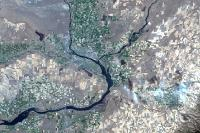

In [3]:
# get image
s2 = gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

## Data Preparation  <a class="anchor" id="5"></a>

## Define Area of Interest in the Amazon
The area of interest is defined using the four latitude and longitude values from a certain region of the Amazon rainforest where a considerable area of forest has been deforested, as can be seen from the images above.

In [4]:
#  extent in 3857 for amazon rainforest
amazon_extent = {
    "xmin": -6589488.51,
    "ymin": -325145.08,
    "xmax": -6586199.09,
    "ymax": -327024.74,
    "spatialReference": {"wkid": 3857}
}

Here, we select all the scenes from the sentinel imagery containing the area of interest for our study.

In [5]:
# The respective scene having the above area is selected
selected = sentinel.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                              geometry=arcgis.geometry.filters.intersects(amazon_extent))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
0,2459960,2020-06-21 14:23:37,20200621T142337_21MTS_0,0.0359,173,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-06-21 14:23:37
1,3343176,2020-07-06 14:23:39,20200706T142339_21MTS_0,0.0037,188,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-07-06 14:23:39
2,3620096,2020-07-21 14:23:37,20200721T142336_21MTS_0,0.0091,203,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-07-21 14:23:37
3,3596177,2020-07-26 14:23:40,20200726T142340_21MTS_0,0.0020,208,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-07-26 14:23:40
4,1584818,2020-07-31 14:23:38,20200731T142337_21MTS_0,0.0000,213,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-07-31 14:23:38
5,776568,2020-08-10 14:23:38,20200810T142338_21MTS_0,0.0039,223,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-08-10 14:23:38
6,556656,2020-08-15 14:23:41,20200815T142340_21MTS_0,0.0087,228,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-08-15 14:23:41
7,1551821,2020-09-04 14:23:39,20200904T142339_21MTS_0,0.0421,248,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-09-04 14:23:39
8,224997,2020-09-19 14:23:37,20200919T142336_21MTS_0,0.0160,263,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2020-09-19 14:23:37


The satellite imagery with the least cloud cover is selected and visualized for further processing.

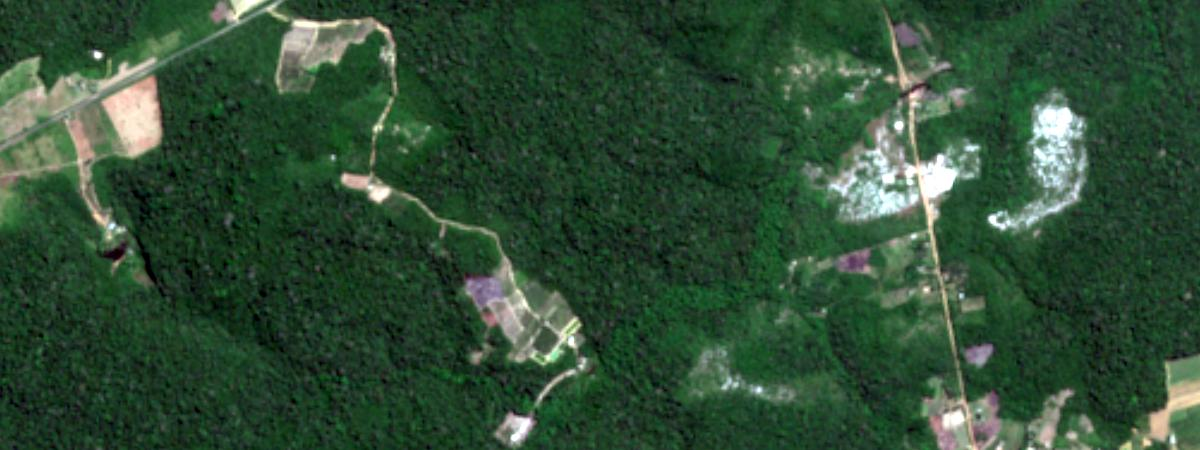

In [6]:
# The scene is selected with the least cloud cover and extracted using the amazon extent
amazon_scene = sentinel.filter_by('OBJECTID=1584818')
amazon_scene.extent = amazon_extent
amazon_scene

In the above scene, the brown patches are the deforested areas that are to be identified. This selected scene is then published to the portal.

In [7]:
# publish the scene to the portal
amazon_scene.save('amazon_scene'+ str(dt.now().microsecond), gis=gis_enterp)

<Item title:"amazon_scene331940" type:Imagery Layer owner:arcgis_python>

The published imagery of the Amazon rainforest is exported back to an image file on disk for further processing.

In [8]:
raster_amazon_13bands = Raster("https://pythonapi.playground.esri.com/ra/rest/services/Hosted/amazon_scene_may26/ImageServer",
                               gis=gis_enterp,
                               engine="image_server")

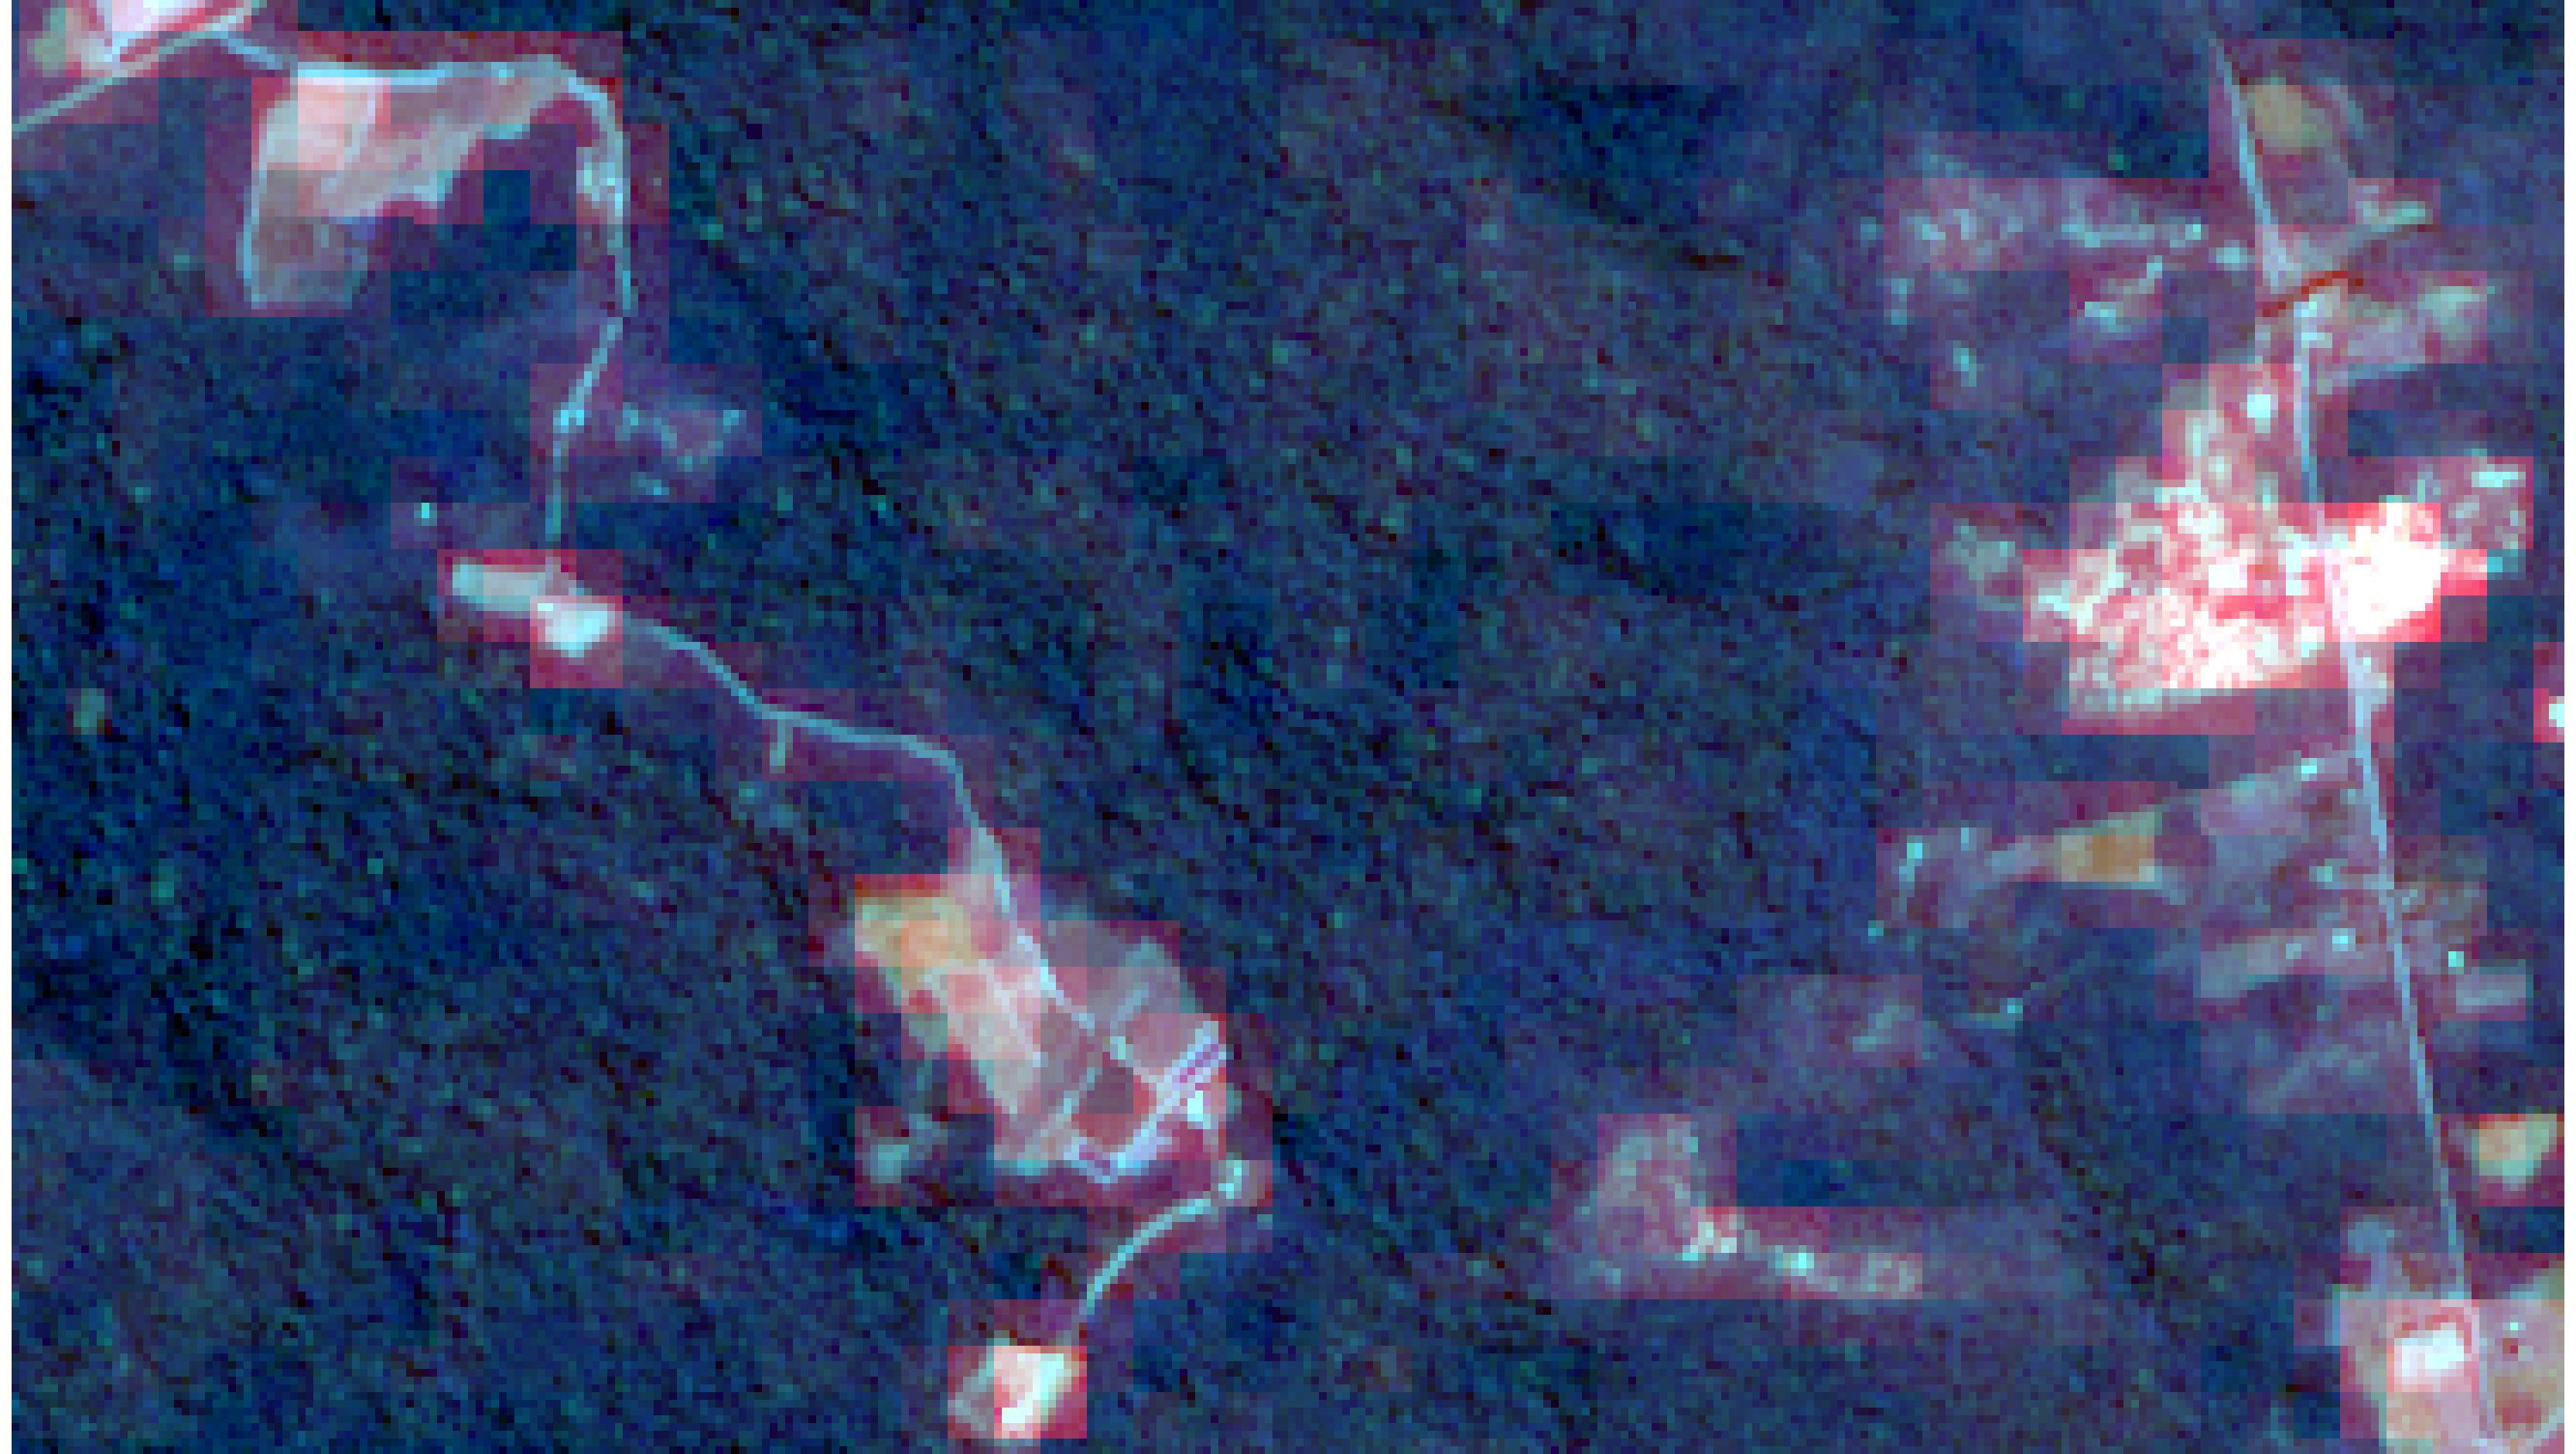

In [9]:
# visualizing the image 
raster_amazon_13bands.export_image(size=[3330,1880])

## Model Building <a class="anchor" id="9"></a>

The first part of model building consists of defining the preprocessors, which will be used to scale the bands before feeding them into the model. The band names use the conventional naming method of the imagery name with an id number appended at the end as follows:

Sentinel-2 imagery has 13 bands, of which 4 bands, namely the blue, green, red, and near infrared bands, we will use here for modelling. These bands work well for differentiating green forested areas from barren land. The band information, along with the band name and their respective ids, are obtained for selecting the required bands.    

In [10]:
# get the band names and their ids, sentinel images have 13 bands
pd.DataFrame(amazon_scene.key_properties()['BandProperties'])

,BandName,WavelengthMin,WavelengthMax
0,B1_Aerosols,433,453
1,B2_Blue,458,522
2,B3_Green,543,577
3,B4_Red,650,680
4,B5_RedEdge,698,712
5,B6_RedEdge,733,747
6,B7_RedEdge,773,793
7,B8_NearInfraRed,784,899
8,B8A_NarrowNIR,855,875
9,B9_WaterVapour,935,955


In [11]:
# get the imagery name to define the band names
raster_amazon_13bands.name

'Hosted/amazon_scene_may26'

Here, the imagery name is 'Hosted/amazon_scene_april9'. Subsequently, the names of the blue, green, red, and near infrared bands would be 'Hosted/amazon_scene_april9_1', 'Hosted/amazon_scene_april9_2', 'Hosted/amazon_scene_april9_3', 'Hosted/amazon_scene_april9_7' respectively. These bands will be used for defining the preprocessors. 

### Data Pre-processing <a class="anchor" id="11"></a>

In [12]:
from sklearn.preprocessing import MinMaxScaler

The four bands are listed in the preprocessors for scaling, with the last item as the designated scaler as follows. 

In [13]:
preprocessors = [('Hosted/amazon_scene_may26_1', 
                  'Hosted/amazon_scene_may26_2', 
                  'Hosted/amazon_scene_may26_3',
                  'Hosted/amazon_scene_may26_7', MinMaxScaler())]

Here, in the explanatory raster, we pass the name of the explanatory raster and the selected bands by their id's — 1 for blue, 2 for green, 3 for red, and 7 for NIR, as follows:

In [14]:
# Data is prepared for the MLModel using the selected scene and the preprocessors
data = prepare_tabulardata(explanatory_rasters=[(raster_amazon_13bands,(1,2,3,7))], preprocessors=preprocessors)

In [15]:
# visualization of the data to be processed by the model
data.show_batch()

,Hosted/amazon_scene_may26_1,Hosted/amazon_scene_may26_2,Hosted/amazon_scene_may26_3,Hosted/amazon_scene_may26_7
647,820,695,406,2508
5345,1144,1155,1181,2303
28764,818,707,389,2901
42042,1201,1252,1257,2596
61515,802,700,388,2410


### Model Initialization <a class="anchor" id="12"></a>

Once the data is prepared, an unsupervised model of k-means clustering from scikit-learn is used for clustering the pixels into deforested areas and forested areas. The clustering model is passed inside MLModel as follows, with the number of clusters set as three in the parameters.

In [16]:
from arcgis.learn import MLModel, prepare_tabulardata

In [17]:
model = MLModel(data, 'sklearn.cluster.KMeans', n_clusters=3, init='k-means++', random_state=43)

### Model Training <a class="anchor" id="14"></a>
Now the model is ready to be trained, and will label the pixels as being one of three classes, either forested, slightly deforested, or highly deforested.  

In [18]:
# here model is trained which would label the pixels into the designated classes 
model.fit()

In [19]:
# the labelled pixels can be visualized as follows with the last column returning the predicted labels by the model 
model.show_results()

,Hosted/amazon_scene_may26_1,Hosted/amazon_scene_may26_2,Hosted/amazon_scene_may26_3,Hosted/amazon_scene_may26_7,prediction_results
25429,811,709,391,3294,2
30113,829,730,397,3261,2
31345,835,767,419,2783,2
32640,986,1015,780,3028,2
55783,815,708,421,2958,2


### Deforestation Clusters Prediction<a class="anchor" id="21"></a>

Next, the trained model is used to predict clusters within the entire selected scene of the Amazon rainforest. This is passed as the explanatory raster, with the prediction type as raster and a local path provided for output. The `output_layer_name` parameter can also be used for publishing. 

In [20]:
pred_new = model.predict(explanatory_rasters=[raster_amazon_13bands],
                         prediction_type='raster',
                         output_layer_name=('deforest_predicted2'+str(dt.now().microsecond)),
                         output_raster_path=r"/tmp/result5.tif")

The Published Item ID is :  3df30cd12a48421dade893490c967c62


## Result Visualization<a class="anchor" id="16"></a>

The resulting raster with the predicted classes of deforested areas and forested areas is now read back for visualization. The predicted local raster can be accessed here.

<Item title:"amazon_deforest_result" type:Image Collection owner:arcgis_python>
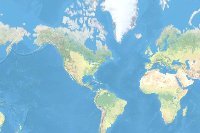

In [21]:
amazon_predict = gis.content.get('b81b89aac4cd4e08bcd7cd400fac558f')
amazon_predict

In [22]:
import os, zipfile

In [23]:
filepath_new = amazon_predict.download(file_name=amazon_predict.name)
with zipfile.ZipFile(filepath_new, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath_new).parent)
output_path = Path(os.path.join(os.path.splitext(filepath_new)[0]))
output_path = os.path.join(output_path, "result5.tif")    

In [24]:
raster_predict = Raster(output_path)

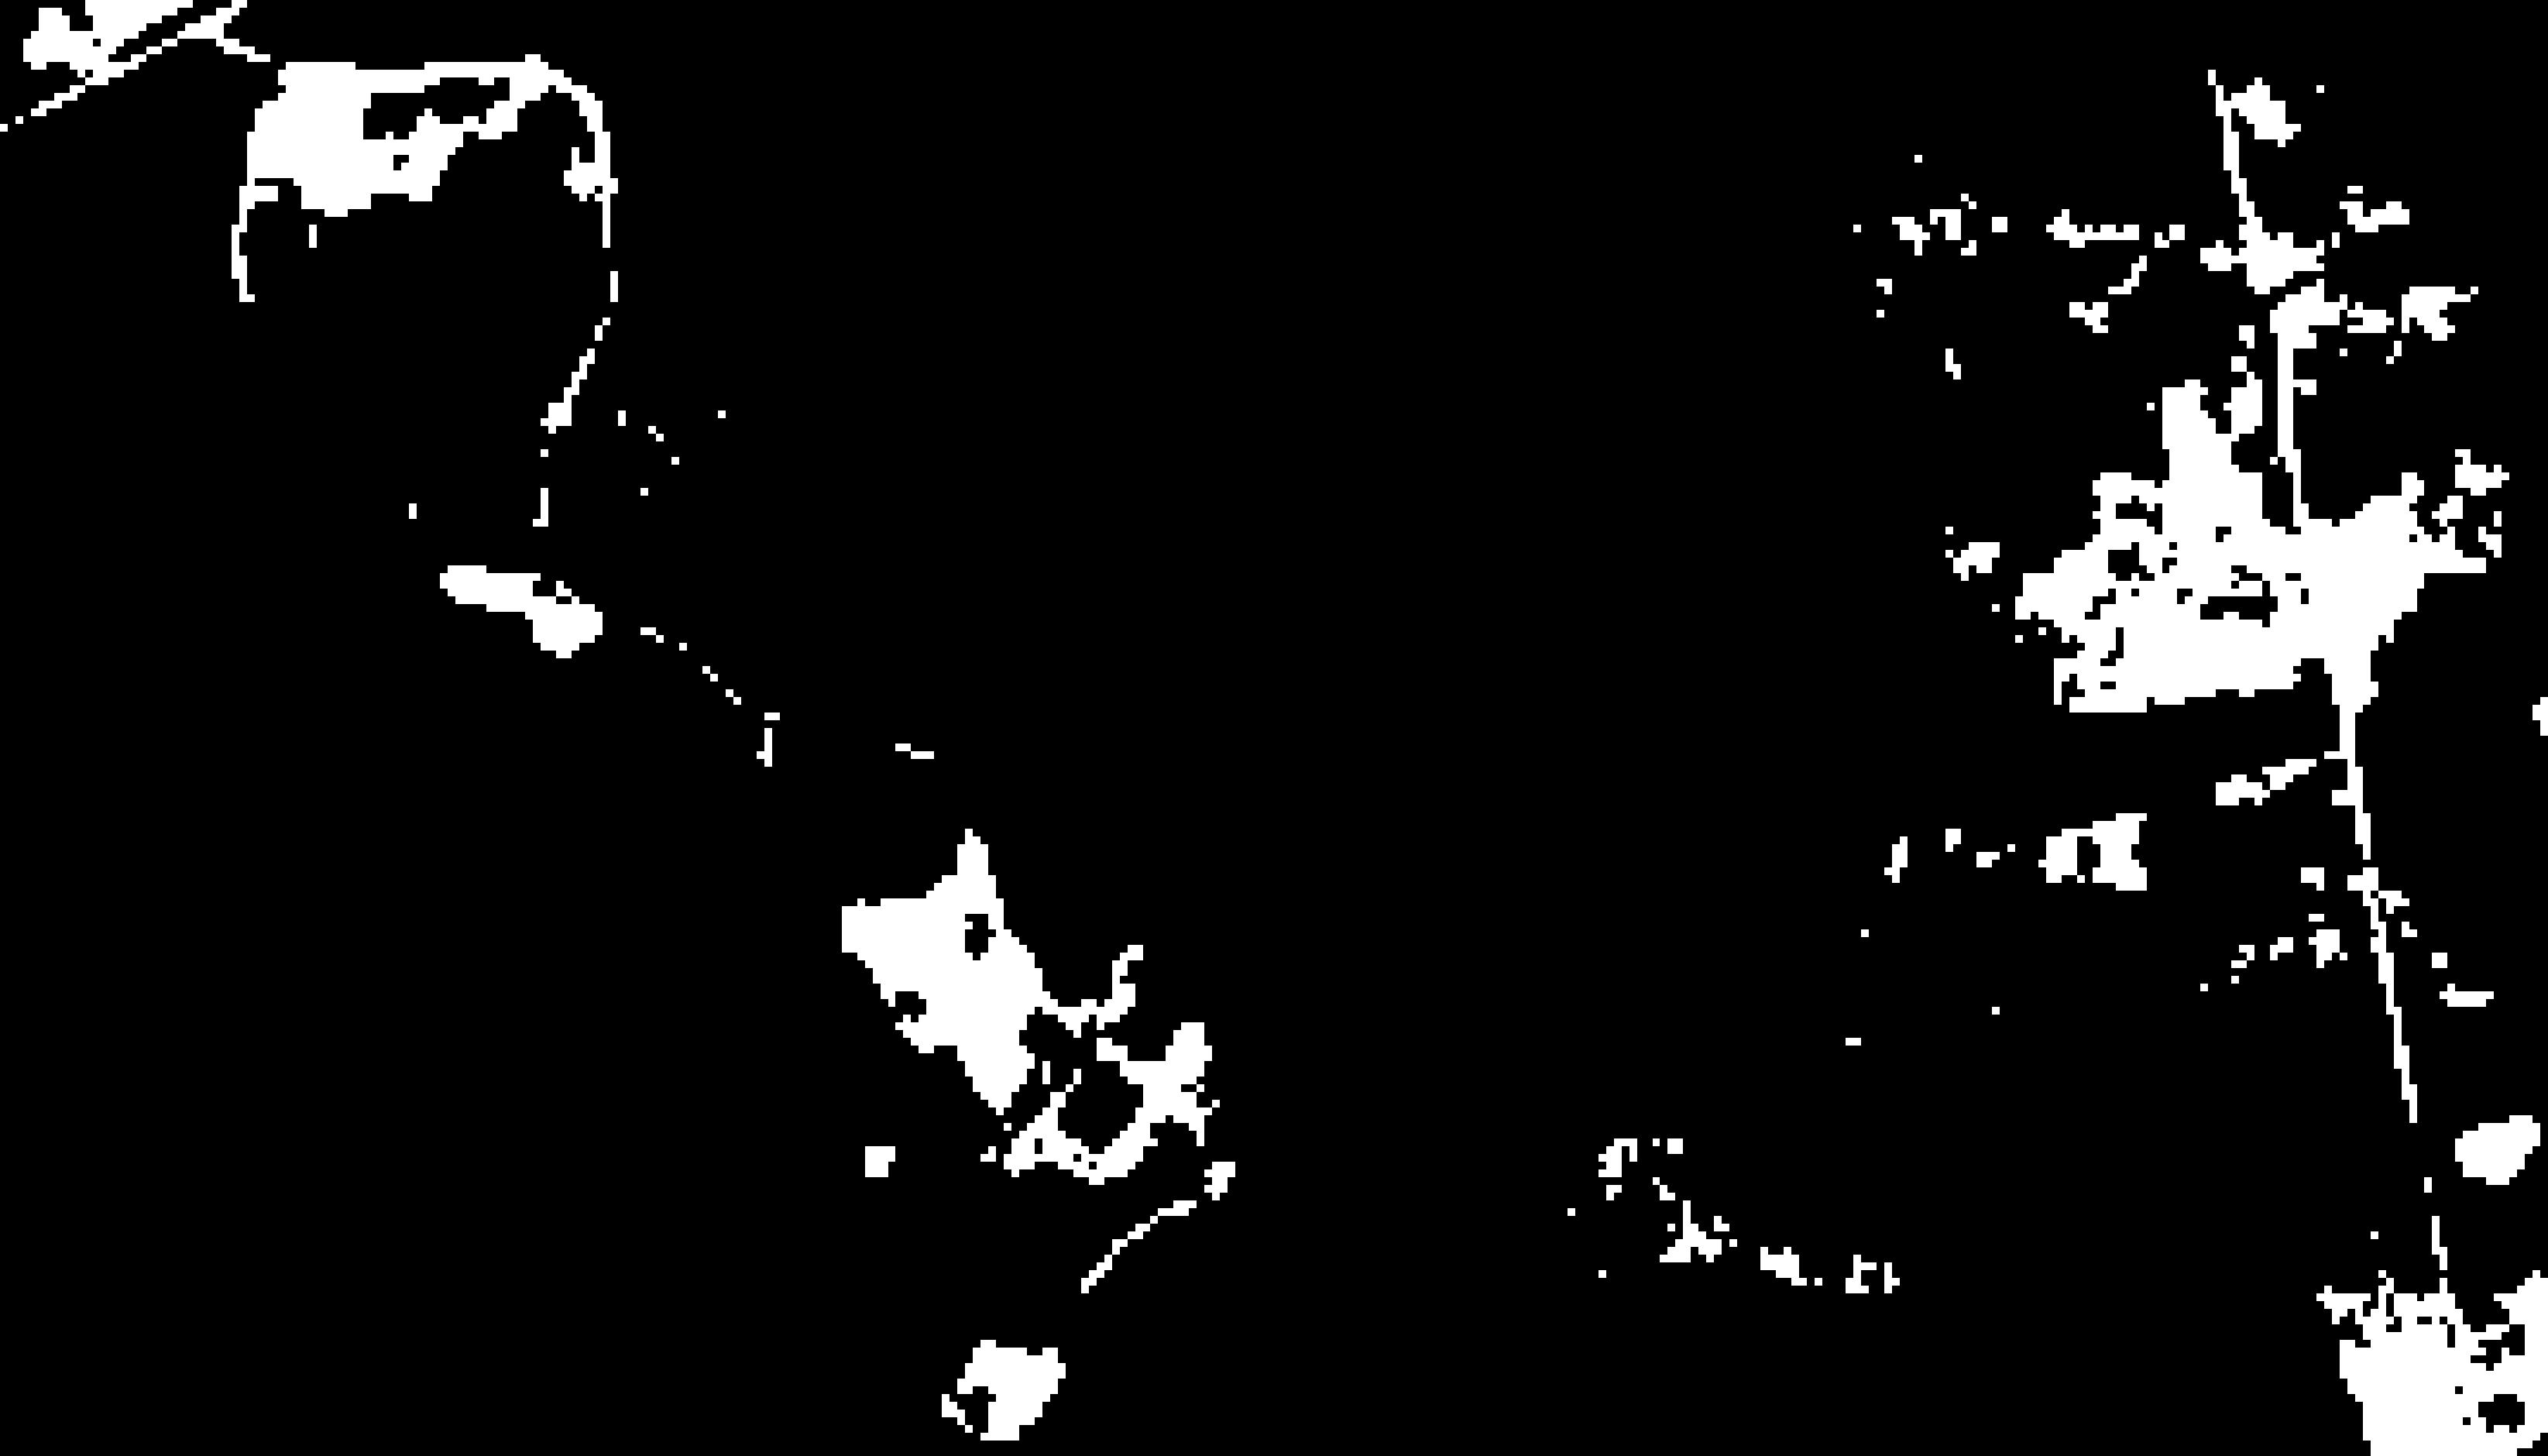

In [25]:
raster_predict.export_image(size=[3290,1880])

The model has correctly labelled the deforested areas in white, distinguishing them from the rest of the forested areas in black.

The boundaries of the detected deforested areas could be further extracted into polygons using the convert raster to feature function.

## Conclusion<a class="anchor" id="23"></a>

In this sample notebook we were able to detect deforestation in the Amazon rainforest using the unsupervised model of k-means clustering on satellite imagery. This was implemented via the MLModel framework, which exhibited the application of several unsupervised models from the scikit learn library on raster imagery.

### Summary of methods used <a class="anchor" id="24"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, normalization and train-test split  |prepare data ready for fitting a  MLModel 
| MLModel() | select the ML algorithm to be used for fitting  | any supervised and unsupervised models from scikit learn can be used
| model.fit() | train a model   | training the unsupervised model with suitable input 
| model.score() | find the appropriate model metric of the trained model  | returns suitable value after training the unsupervised MLModel
| model.predict() | predict on a test set | predict values using the trained models on the trained data itself

### Data resources <a class="anchor" id="25"></a>

| Dataset | Source | Link |
| -| - |-|
| sat imagery| sentinel2  |https://registry.opendata.aws/sentinel-2/|